# Two dimensional Cartesian Slepians, generalized

The idea here is to use slepian_foxtrot to jumpstart an implementation of the Simons code. We should be able to then localize blobs, or splined boundaries of things in order to get the GL nodes and solve the concentration problem. 

`slepian_foxtrot` depends on `slepian_alpha`, so the routines from `slepian_alpha` that are needed have been collected in an input file. 

In [2]:
using FastGaussQuadrature, Plots, DelimitedFiles, Random, Slepians, KernelMatrices, Interpolations
using KrylovKit, IterTools, FFTW #, LaTeXStrings
Random.seed!(123)

#include("relevant_slepian_alpha.jl")

include("RHMatrix.jl")

[ Info: Precompiling Slepians [97caf2bd-9cc0-4738-8821-c8999f46f3c9]


Main.RHMatrix

## Random blob example

In [ ]:
""" 

    randcirc(xm, ym, r,dr, N)

# Arguments
- xm horizontal position of the center
- ym vertical position of the center
- `r` radius
- `dr` size of random perturbations around the radius
- `N` number of random spike points

# Outputs
- `x` x-coordinate
- `y` y-coordinate

# Related
@blob

"""
#function randcirc2(xm = 0.0, ym = 0.0, r = 1.0, dr = 1, N = 10)
#    nr = 100
#    r = [r + 2*dr*(rand() .- 0.5) for x in 1:N]
#    r = vcat(r[end],r,r[1])
#    t = -1.:1:N
#    
#    itp = interpolate(r, BSpline(Cubic(Line(OnGrid()))))
#    sitp = scale(itp, t)
#    xfine = 0.0:.01:N
#    xs = [sitp(x) for x in xfine]#

#    p1 = scatter(xfine, xs)
#    scatter!(t, r)

#    p2 = scatter()
#    scatter!(p2, r.*cos.(2*pi*t), r.*sin.(2*pi*t))
#    
#    return xm .+ xs.*cos.(2*pi*xfine/N), ym .+ xs.*sin.(2*pi*xfine/N)
#end

x,y = Slepians.randcirc2(0.0,0.0,1.0,1,4)

plot(x,y)

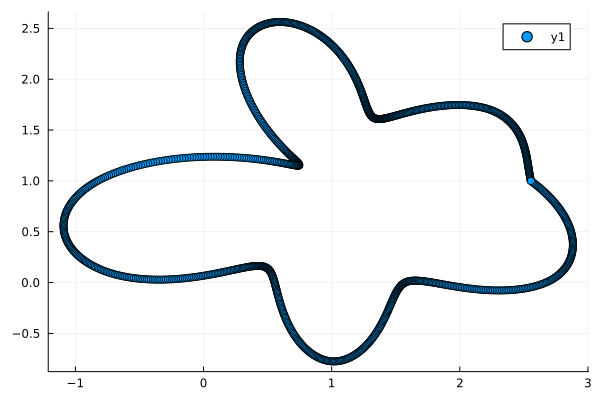

In [179]:
x,y = randcirc2(1.0,1.0,1.0,1,12)

scatter(x,y)

In [65]:

    sitp = scale(itp, t)

   

LoadError: MethodError: no method matching scale(::Interpolations.BSplineInterpolation{Float64, 1, OffsetArrays.OffsetVector{Float64, Vector{Float64}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{Base.OneTo{Int64}}}, ::Vector{Float64})

[0mClosest candidates are:
[0m  scale(::AbstractInterpolation{T, N, IT}, [91m::Tuple{Vararg{var"#s217", N}} where var"#s217"<:AbstractRange[39m) where {T, N, IT}
[0m[90m   @[39m [36mInterpolations[39m [90m~/.julia/packages/Interpolations/91PhN/src/scaling/[39m[90m[4mscaling.jl:31[24m[39m
[0m  scale(::AbstractInterpolation{T, N, IT}, [91m::AbstractRange...[39m) where {T, N, IT}
[0m[90m   @[39m [36mInterpolations[39m [90m~/.julia/packages/Interpolations/91PhN/src/scaling/[39m[90m[4mscaling.jl:27[24m[39m


In [2]:
x, y = Slepians.blob(1,1)

p = scatter(x[1], y[1],  marker = :o, title = "Boundary", legend = false)

LoadError: UndefVarError: `PCHIPInterpolation` not defined

## Get the quadrature nodes

In [3]:
QX, QY, w, Nrun = get_quadrature_nodes_2D(x[1], y[1], 16, 16)

# Initialize the quadrature points
scatter!(p, QX, QY, legend = false)

LoadError: UndefVarError: `x` not defined

## Integrate

Now we just use the code that does the numerical integration, and Bob's your uncle.

In [4]:
include("ext.jl")

customsleps_ext (generic function with 1 method)

In [5]:
# Set the parameters for the custom Slepians

M  = 3
Kp = [4.0]
szs = int = (16, 16)
prec = 1e-8
exact = false
lvl = 6
maxrank = 256


256

In [6]:
no    = map(i->(QX[i], QY[i]), 1:prod(size(QX)))
sqwt = sqrt.(w[:]);

LoadError: UndefVarError: `QX` not defined

Get the nodes and weights into the sizes and shapes that the solving routine wants.

In [7]:
ev = vec(collect(product([range(minimum(QX), maximum(QX), length = szs[1]), range(minimum(QY), maximum(QY), length = szs[2]) ]...)))
s, sl = customsleps_ext(M, Kp, szs, prec = prec, exact = exact, lvl = lvl, maxrank = maxrank, no = no,
        sqwt = sqwt, int = nothing, ev = ev);
s

LoadError: UndefVarError: `QX` not defined

Plot the results

In [8]:
p1 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
p2 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
ran = 1:4
for i = ran
    p1[i] = heatmap(range(minimum(QX), maximum(QX), length = szs[1]), 
         range(minimum(QY), maximum(QY), length = szs[2]), Float64.(sl[i])',
        c = :RdBu, clims = (-1.25, 1.25), ylabel = latexstring("\\lambda^$i"))
    # this transpose is important
    plot!(p1[i], x[1], y[1], legend = false, c = :black)

    SL = abs2.(fftshift(fft(sl[i])))
    p2[i] = heatmap(range(-1.0, 1.0, length=szs[2]+1)[1:szs[2]],range(-1.0, 1.0, length=szs[1]+1)[1:szs[1]],
        log10.(SL), ylabel = i)
end

plot(p1[ran]...)

LoadError: UndefVarError: `sl` not defined

In [9]:
qq = plot(p2[ran]..., legend = false)

for i = 1:4
    plot!(qq[i], (Kp[1]/szs[1])*cos.(range(-pi, pi, length=30)), 
        (Kp[1]/szs[2])*sin.(range(-pi, pi, length=30)), c = :black)
end

qq

LoadError: UndefVarError: `p2` not defined

## Second example - rattle shape

How does the code set up quadrature nodes for disjoint circles?

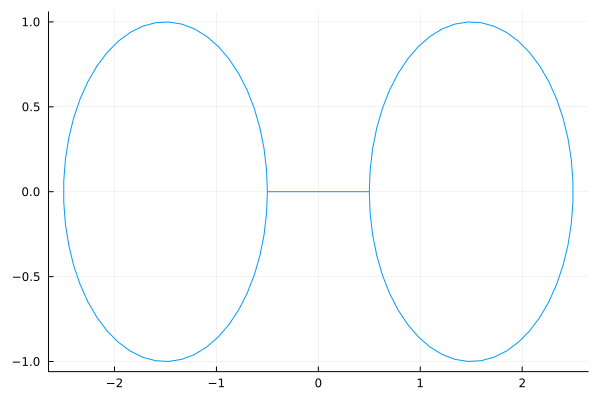

In [10]:
N = 50
t = LinRange(-pi, pi, N)
x1, y1 = (cos.(t) .+ 1.5, sin.(t))
x2, y2 = (cos.(t .+ pi) .- 1.5, sin.(t .+ pi))
xp,yp = (vcat(x1, x2), vcat(y1, y2))

plot(xp,yp, legend = false)

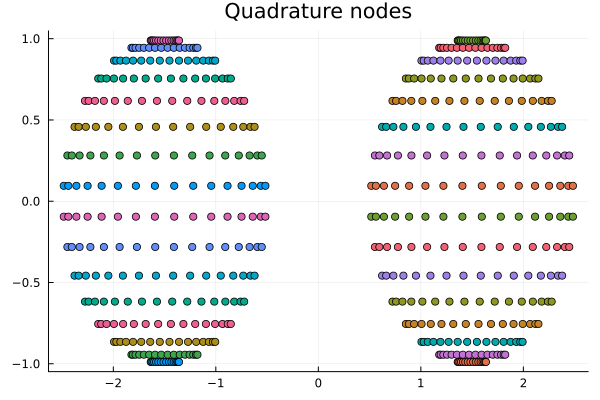

In [11]:
QXp, QYp, wp, Nrunp = get_quadrature_nodes_2D(xp, yp, 16, 16)
psp = scatter(QXp, QYp, legend = false, title = "Quadrature nodes")

In [12]:
nop    = map(i->(QXp[i], QYp[i]), 1:prod(size(QXp)))
sqwtp = sqrt.(wp[:]);
size(sqwtp)

(512,)

In [13]:
evp = vec(collect(product([range(minimum(QXp), maximum(QXp), length = szs[1]), range(minimum(QYp), maximum(QYp), length = szs[2]) ]...)))
M = 1
sp, slp = customsleps_ext(M, Kp, szs, prec = prec, exact = exact, lvl = lvl, maxrank = maxrank, no = nop,
        sqwt = sqwtp, int = nothing, ev = evp);

LoadError: UndefVarError: `RHMatrix` not defined

In [14]:
p1 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
p2 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
ran = 1:4
for i = ran
    p1[i] = heatmap(range(minimum(QXp), maximum(QXp), length = szs[1]), 
         range(minimum(QYp), maximum(QYp), length = szs[2]), Float64.(slp[i])',
        c = :RdBu, ylabel = i, clims = (-0.7, 0.7)) # this transpose is important
    plot!(p1[i], xp, yp, legend = false, c = :black)

    SL = abs2.(fftshift(fft(slp[i])))
    p2[i] = heatmap(range(-1.0, 1.0, length=szs[2]+1)[1:szs[2]],0.5*range(-1.0, 1.0, length=szs[1]+1)[1:szs[1]],
        log10.(SL), ylabel = i)
end

plot(p1[ran]...)
#png("rattle")

LoadError: UndefVarError: `sl` not defined

In [15]:
qq = plot(p2[ran]..., legend = false)

for i = 1:4
    plot!(qq[i], (Kp[1]/szs[1])*cos.(range(-pi, pi, length=30)), 
        (Kp[1]/szs[2])*sin.(range(-pi, pi, length=30)), c = :black)
end

qq
#png("locrattle")

LoadError: UndefVarError: `p2` not defined

In [16]:
plot(p2[2])
plot!(p2[2], (Kp[1]/szs[1])*cos.(range(-pi, pi, length=30)), 
        (Kp[1]/szs[2])*sin.(range(-pi, pi, length=30)), c = :black)

plot(p1[2], p2[2], title = ["Q-space" "Correlation Space"], size = (900, 350), 
    colorbar_title = ["Magnitude" "log abs value"], 
    xlabel = ["Qh" "x"], ylabel = ["Qk" "y"],
    layout = (1,2), legend = false)
png("rattle")

LoadError: UndefVarError: `p2` not defined

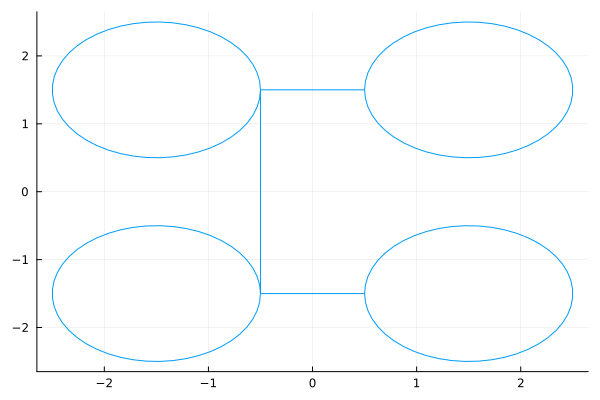

In [17]:
N = 50
t = LinRange(-pi, pi, N)
x1, y1 = (cos.(t) .+ 1.5, sin.(t) .+ 1.5)
x2, y2 = (cos.(t .+ pi) .- 1.5, sin.(t .+ pi) .+ 1.5)
x3, y3 = (cos.(t .+ pi) .- 1.5, sin.(t .+ pi) .- 1.5)
x4, y4 = (cos.(t) .+ 1.5, sin.(t) .- 1.5)

xp,yp = (vcat(x1, x2, x3, x4, x3[1], x2[1], x1[1]), vcat(y1, y2, y3, y4, y3[1], y2[1], y1[1]))

plot(xp,yp, legend = false)

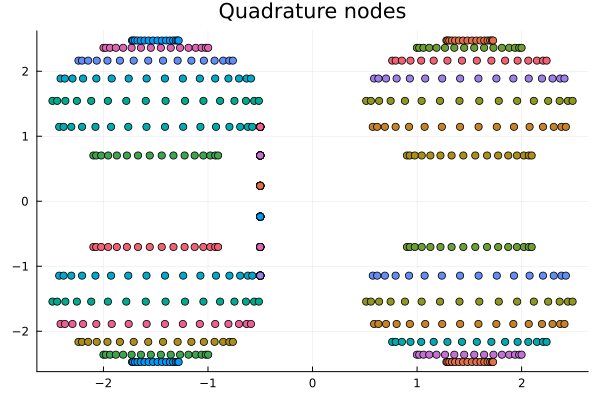

In [18]:
QXp, QYp, wp, Nrunp = get_quadrature_nodes_2D(xp, yp, 16, 16)
psp = scatter(QXp, QYp, legend = false, title = "Quadrature nodes")

In [19]:
nop    = map(i->(QXp[i], QYp[i]), 1:prod(size(QXp)))
sqwtp = sqrt.(wp[:]);
size(sqwtp)

evp = vec(collect(product([range(minimum(QXp), maximum(QXp), length = szs[1]), range(minimum(QYp), maximum(QYp), length = szs[2]) ]...)))

sp, slp = customsleps_ext(M, Kp, szs, prec = prec, exact = exact, lvl = lvl, maxrank = maxrank, no = nop,
        sqwt = sqwtp, int = nothing, ev = evp);

LoadError: UndefVarError: `RHMatrix` not defined

In [20]:
p1 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
p2 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
ran = 1:4
for i = ran
    p1[i] = heatmap(range(minimum(QXp), maximum(QXp), length = szs[1]), 
         range(minimum(QYp), maximum(QYp), length = szs[2]), Float64.(slp[i])',
        c = :RdBu, ylabel = i, clims = (-0.7, 0.7)) # this transpose is important
    plot!(p1[i], xp, yp, legend = false, c = :black)

    SL = abs2.(fftshift(fft(slp[i])))
    p2[i] = heatmap(0.5*range(-1.0, 1.0, length=szs[2]+1)[1:szs[2]],0.5*range(-1.0, 1.0, length=szs[1]+1)[1:szs[1]],
        log10.(SL), ylabel = i)
end

plot(p1[ran]...)
#png("circles")

LoadError: UndefVarError: `sl` not defined

In [21]:
qq = plot(p2[ran]..., legend = false)

for i = 1:4
    plot!(qq[i], (Kp[1]/szs[1])*cos.(range(-pi, pi, length=30)), 
        (Kp[1]/szs[2])*sin.(range(-pi, pi, length=30)), c = :black)
end

qq
#png("circles_loc")

LoadError: UndefVarError: `p2` not defined